## 1. Load data

In [95]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
%matplotlib inline

## 2. Create function to generate dataset at specific size

In [97]:
def get_datasets(target_size=29):
    assert target_size <= 29 and target_size % 2 == 1
    dataset_transforms = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.Pad( (29-target_size) // 2 ),
        transforms.ToTensor(),
    ])
    train_dataset = datasets.MNIST('./data', train=True, transform=dataset_transforms, target_transform=None, download=True)
    
    train_size = int(0.8 * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    
    torch.manual_seed(42) # keep same seed everytime
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])
    test_dataset = datasets.MNIST('./data', train=False, transform=dataset_transforms, target_transform=None, download=True)
    return dict(train=train_dataset, valid=valid_dataset, test=test_dataset)

def show_tensor_image(image):
    plt.imshow(transforms.ToPILImage()(image), cmap='gray');
    
def get_dataloaders(data):
    dataloaders = dict(
        train=DataLoader(data['train'], batch_size=32, shuffle=True, num_workers=6),
        valid=DataLoader(data['valid'], batch_size=32, shuffle=False, num_workers=6),
        test=DataLoader(data['test'], batch_size=32, shuffle=False, num_workers=6),
    )
    return dataloaders

In [98]:
data = get_datasets(target_size=21)
len(data['train']), len(data['test'])

(48000, 10000)

In [99]:
x, y = data['train'][0]
type(x), type(y), x.shape

(torch.Tensor, int, torch.Size([1, 29, 29]))

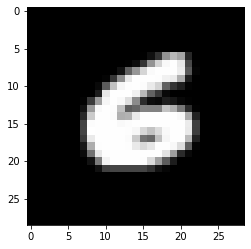

In [100]:
show_tensor_image(x)

## 3. Create model class and get_model function

In [101]:
class MCDNN1(nn.Module):
    def __init__(self):
        super(MCDNN1, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN2(nn.Module):
    def __init__(self):
        super(MCDNN2, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN3(nn.Module):
    def __init__(self):
        super(MCDNN3, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN4(nn.Module):
    def __init__(self):
        super(MCDNN4, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=3)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1)
    
class MCDNN(nn.Module):
    def __init__(self):
        super(MCDNN, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=3)),
            ('flatten', Flatten()),
            ('fc1', nn.Linear(in_features=40*3*3, out_features=150)),
            ('relu3', nn.ReLU()),
            ('fc2', nn.Linear(in_features=150, out_features=10)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

data = get_datasets(target_size=21)
dataloaders = get_dataloaders(data)
batch_x, batch_y = next(iter(dataloaders['train']))
print('first layer', MCDNN1()(batch_x).shape)
print('second layer', MCDNN2()(batch_x).shape)
print('third layer', MCDNN3()(batch_x).shape)
print('fourth layer', MCDNN4()(batch_x).shape)
print('final layer', MCDNN()(batch_x).shape)

first layer torch.Size([32, 20, 26, 26])
second layer torch.Size([32, 20, 13, 13])
third layer torch.Size([32, 40, 9, 9])
fourth layer torch.Size([32, 40, 3, 3])
final layer torch.Size([32, 10])


## 4. Create training function to train a model given ```dataloaders['train']``` and ```dataloaders['valid']```

In [110]:
def train_model(dataloaders, model, loss_func, optimizer, scheduler=None, device="cuda:0", epochs=1, save_func=None):
    
    def train_epoch():
        model.train()
        total_loss = 0
        for batch_x, batch_y in dataloaders['train']:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            loss = loss_func(pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()
            
            total_loss += loss.item()
        return total_loss / len(dataloaders['train'])
            
    def valid_epoch():
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloaders['valid']:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                pred = model(batch_x)
                loss = loss_func(pred, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloaders['valid'])
    
    train_loss, valid_loss = [], []
    best_valid_loss = float('inf')
    pbar = tqdm(range(epochs), total=epochs)
    for epoch in pbar:
        train_loss.append(train_epoch())
        valid_loss.append(valid_epoch())
        pbar.set_description(f'epoch {epoch} current best {best_valid_loss:.3f}')
        if save_func is not None:
            if valid_loss[-1] < best_valid_loss:
                save_message = save_func(model)
                best_valid_loss = valid_loss[-1]
                pbar.set_description(f'epoch {epoch} new best {valid_loss[-1]:.3f} {save_message}')
    return train_loss, valid_loss
                
def save_func(target_size, column):
                
    def __save_func(model):
        model_path = f'./models/model_{target_size}_{column}.pth'
        torch.save(dict(state_dict=model.state_dict()), model_path)
        return f'saved to {model_path}'
    
    return __save_func

data = get_datasets(target_size=29)
dataloaders = get_dataloaders(data)

device = "cuda:0"
epochs = 1
model = MCDNN().to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
train_model(dataloaders, model, loss_func, optimizer, epochs=epochs, device=device, save_func=save_func(29, 0))


epoch 0 new best 0.076 saved to ./models/model_29_0.pth: 100%|██████████| 1/1 [00:13<00:00, 13.00s/it]


## 5. Train all models and save best models to ```./models``` folder

In [ ]:
for target_size in [29, 27, 25, 21, 17, 13, 11]:
    for column in range(5):
        data = get_datasets(target_size=target_size)
        dataloaders = get_dataloaders(data)

        device = "cuda:0"
        epochs = 10
        model = MCDNN().to(device)
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
        train_model(dataloaders, model, loss_func, optimizer, epochs=epochs, device=device, save_func=save_func(target_size, column))

epoch 3 current best 0.04043356861670812:  40%|████      | 4/10 [00:53<01:20, 13.34s/it]               